In [18]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore') # for ignoring annoying warnings

In [19]:
from energinet_functions import load_power_data, plot_power_system # import the functions from energinet

In [20]:
# start and end of loaded data
start_data = '2024-01-01'
end_data = '2025-01-01'

# Load the data
dataframe = load_power_data(start_data, end_data)

# Check all columns in the dataframe
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8783 entries, 2024-01-01 00:00:00 to 2024-12-31 23:00:00
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TotalLoad                8783 non-null   float64
 1   Biomass                  8783 non-null   float64
 2   FossilGas                8783 non-null   float64
 3   FossilHardCoal           8783 non-null   float64
 4   FossilOil                8783 non-null   float64
 5   HydroPower               8783 non-null   float64
 6   OtherRenewable           8783 non-null   float64
 7   SolarPower               8783 non-null   float64
 8   Waste                    8783 non-null   float64
 9   OnshoreWindPower         8783 non-null   float64
 10  OffshoreWindPower        8783 non-null   float64
 11  ExchangeContinent        8783 non-null   float64
 12  ExchangeGreatBelt        8783 non-null   float64
 13  ExchangeNordicCountries  8783 non-null   f

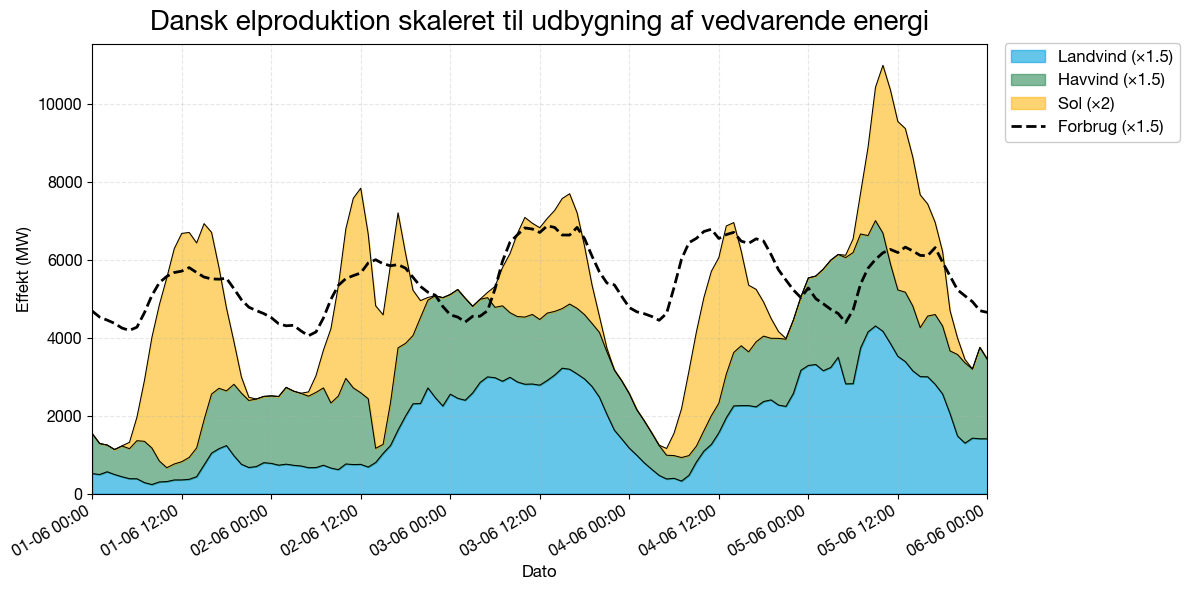

In [21]:
# Make the plot

# Data types to plot
data_to_plot = ['OnshoreWindPower', 'OffshoreWindPower', 'SolarPower'] # Add the other technologies from the dataframe if wanted

# Dictionary with scaling factors
scale_factors = {
    'OnshoreWindPower':  1.5,
    'OffshoreWindPower': 1.5, 
    'SolarPower':        2,
    'TotalLoad':         1.5
}

# Start and end of the plot
start_plot = '2024-06-01'
end_plot = '2024-06-06'

# Title of the plot
titel = 'Dansk elproduktion skaleret til udbygning af vedvarende energi'

# Call the plotting function from energinet_functions
plot_power_system(dataframe, data_to_plot, scale_factors=scale_factors, start=start_plot,end=end_plot, title=titel, plot_load=True)

# Save the figure in high resolution
plt.savefig('Elsystem.jpg', dpi=800, bbox_inches='tight')